
# NLP From Scratch: Generating Names with a Character-Level RNN

This time we'll generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

It would also be useful to know about RNNs and how they work:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   is about LSTMs specifically but also informative about RNNs in
   general

## Preparing the Data

In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.


This code block is for preparing and loading the data for a name classification task. It defines the set of valid characters for names and functions for reading and preprocessing the data. It reads in text files containing names categorized by origin and converts the names to plain ASCII format. It also prints the number and list of categories and an example of a name after conversion to ASCII format.






In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Czech', 'Vietnamese', 'Polish', 'Portuguese', 'Spanish', 'Scottish', 'English', 'Irish', 'Japanese', 'Dutch', 'German', 'Korean', 'Chinese', 'Greek', 'Russian', 'French', 'Italian']
O'Neal


## Creating the Network


We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I add a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which [randomly zeros parts of its
input](https://arxiv.org/abs/1207.0580)_ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.


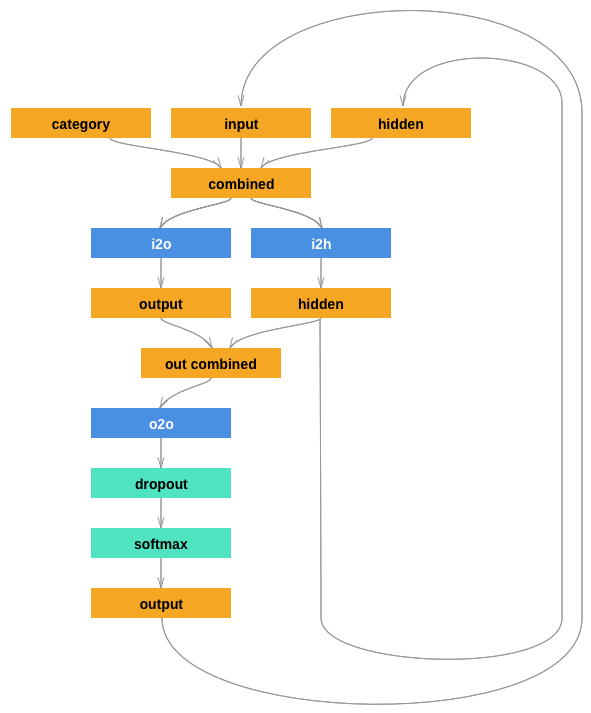

This code block defines a class called RNN, which inherits from the nn.Module class in PyTorch. The RNN class defines a recurrent neural network model that takes as input a category (e.g. language) and a sequence of characters and produces an output probability distribution over a set of target categories. The RNN has three linear layers (i2h, i2o, and o2o) and a dropout layer, which are used to combine the inputs and hidden states and generate outputs. The model also has an initialization method called initHidden, which initializes the hidden state of the model to a tensor of zeros.






In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Training
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




This code block defines two functions: randomChoice(l) and randomTrainingPair(). The randomChoice(l) function takes a list l and returns a random element from it. The randomTrainingPair() function returns a random category and a random line from that category, chosen from the global variables all_categories and category_lines, respectively.






In [3]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

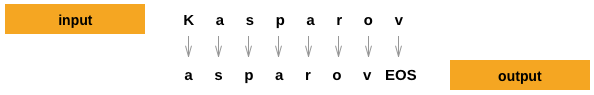

The category tensor is a [one-hot
tensor](https://en.wikipedia.org/wiki/One-hot)_ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




This code block defines three functions to convert text data into PyTorch tensors for training a model. The categoryTensor function takes a category and returns a one-hot encoded tensor representing that category. The inputTensor function takes a string and returns a one-hot encoded tensor representing the characters of that string. The targetTensor function takes a string and returns a tensor of the indices of the characters in the string, excluding the first character and including an end-of-string marker.






In [4]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




This code block defines a function randomTrainingExample() that generates a random training example. The function selects a random category and a random line from that category, and then creates one-hot tensors for the category, input (line), and target (next letter) using the previously defined helper functions categoryTensor(), inputTensor(), and targetTensor(), respectively. The function returns these three tensors as a tuple.






In [5]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### Training the Network

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




This code block defines the training function for the RNN model. It takes the category tensor, input line tensor, and target line tensor as inputs. It initializes the hidden state, sets the gradient of the RNN to zero, and computes the loss by iterating through each character in the input line tensor and passing it through the RNN. It then calculates the gradient of the loss with respect to the parameters of the RNN and updates the parameters using stochastic gradient descent. Finally, it returns the output and the average loss per character. The loss function used is negative log likelihood loss.






In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




This code defines a function timeSince that takes in a starting time since and returns the time elapsed in minutes and seconds since that starting time. The function uses the time and math modules to calculate the elapsed time in minutes and seconds, and then formats and returns the result as a string.






In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




This code block sets up a loop to train the RNN model. It initializes the model with 128 hidden units, and trains it for a specified number of iterations (n_iters). During each iteration, a random training example is used to update the model parameters by calling the train() function. The loss value obtained from each iteration is added to the total_loss variable, which is reset after every plot_every iterations. After every print_every iterations, the current loss value and progress percentage are printed to the console. Additionally, after every plot_every iterations, the average loss over the last plot_every iterations is added to the all_losses list. The training process is timed using the timeSince() function.






In [8]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 16s (5000 5%) 2.8867
0m 34s (10000 10%) 2.6582
0m 50s (15000 15%) 2.1031
1m 6s (20000 20%) 2.8222
1m 22s (25000 25%) 2.8332
1m 38s (30000 30%) 1.5467
1m 54s (35000 35%) 3.8945
2m 10s (40000 40%) 3.1977
2m 25s (45000 45%) 3.2364
2m 42s (50000 50%) 3.0461
2m 58s (55000 55%) 1.9047
3m 14s (60000 60%) 2.5263
3m 29s (65000 65%) 3.1384
3m 46s (70000 70%) 2.2382
4m 2s (75000 75%) 2.5425
4m 17s (80000 80%) 2.4815
4m 33s (85000 85%) 1.8575
4m 50s (90000 90%) 3.1781
5m 5s (95000 95%) 0.8830
5m 21s (100000 100%) 2.5630


### Plotting the Losses

Plotting the historical loss from all\_losses shows the network
learning:




This code block imports the matplotlib.pyplot module and creates a new figure object. It then plots the values in the all_losses list, which is a list of the average losses over each plot_every iterations during the training loop. Finally, the plt.show() function is called to display the plot.






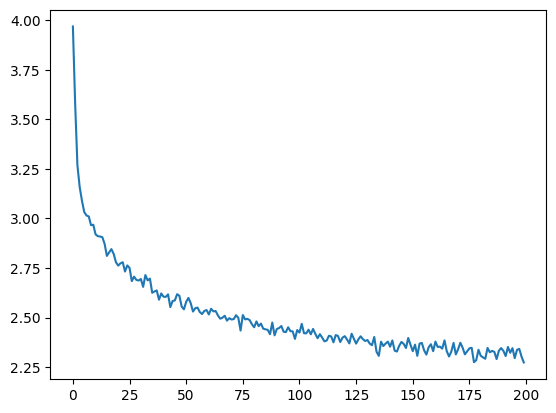

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## Sampling the Network

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




This code block defines a function to sample names from different categories using a trained RNN model. It first sets a maximum length for the generated names, and then defines a "sample" function that takes a category and a starting letter as inputs, and generates a name by predicting the next letter using the RNN model. The function stops generating when either the maximum length is reached or the predicted letter is the end-of-string token. The code then defines a "samples" function that takes a category and a string of starting letters as inputs, and calls the "sample" function for each starting letter to generate multiple names for the given category. The code finally calls the "samples" function for four different categories and prints the generated names.






In [10]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovako
Uanton
Shaver
Gerrer
Eren
Romer
Santara
Para
Arana
Cha
Han
Iha
